In [19]:
from datetime import datetime
import json
from utils import load_all_llm_answers_from_json
import pandas as pd

## TO DO
- HEATMAP of each model and whether they get the same questions wrong or not
- Add probabilistic outputs to each model answer
- Add "abstain" option for all models

In [20]:
answers_save_path = './2024-07-20-Multi-Benchmark/auto_eval_outputs'

all_llm_answers = load_all_llm_answers_from_json(answers_save_path, prefix_replace='auto_eval-')

all_llm_answers

{'claude-3-5-sonnet-20240620':      level_0  index         category  \
 0          0      1           Puzzle   
 1          1      2           Puzzle   
 2          2      3          Spatial   
 3          3      4           Puzzle   
 4          4      5           Puzzle   
 ..       ...    ...              ...   
 295      295     26           Puzzle   
 296      296     27           Puzzle   
 297      297     28  Popular science   
 298      298     29       Relational   
 299      299     30  Popular science   
 
                                               question  \
 0    You have six horses and want to race them to s...   
 1    Suppose you're on a game show, and you're give...   
 2    You are playing Russian roulette with a six-sh...   
 3    A farmer wants to cross a river and take with ...   
 4    Bob has three boxes in front of him - Box A, B...   
 ..                                                 ...   
 295  A runaway trolley is heading down the tracks a...   
 296

In [21]:
all_llm_answers[list(all_llm_answers.keys())[0]].head(1)

,level_0,index,category,question,human_answer,correct_answer,multiple_choice,multi_choice_question,correct_letter,model_answer,score,json_answer,json_answer_letter,invalid_answer_letter
0,0,1,Puzzle,You have six horses and want to race them to s...,Race them on a single race track with at least...,One,"[Three, One, Two, Unknown]",QUESTION\nYou have six horses and want to race...,B,Let's think through this step-by-step:\n\n1. W...,0,{'ANSWER': 'C'},C,0


In [22]:
# # Sanity check to see if the scores are being calculated correctly in the below cells after a low of manipulation
# model_scores = []
# for llm_model in list(all_llm_answers.keys()):
#     correct_answer = all_llm_answers[llm_model]['correct_letter'] == all_llm_answers[llm_model]['json_answer_letter']
#     percentage_correct = correct_answer.value_counts(normalize=True)[True] * 100
#     initial_score = all_llm_answers[llm_model]['score'].mean()
#     dict_results = {
#         'model': llm_model,
#         'percentage_correct': percentage_correct,
#         'initial_score': initial_score
#     }
#     model_scores.append(dict_results)

# model_scores_series = pd.DataFrame(model_scores).sort_values(by='percentage_correct', ascending=False)
# model_scores_series

In [46]:
moe_llm_answers = {}
for llm_model in list(all_llm_answers.keys()):
    answer_subset = all_llm_answers[llm_model]
    data = answer_subset[[
        'index', 'question', 'multiple_choice', 'correct_answer',
        'multi_choice_question', 'correct_letter', 'json_answer_letter',
    ]]
    moe_llm_answers[llm_model] = []
    for idx, row in data.iterrows():
        # if idx > 0:
        #     continue
        normalized_choices_dict_inv = dict(zip(sorted(row['multiple_choice']), ['A', 'B', 'C', 'D']))
        presented_choices_dict = dict(zip(['A', 'B', 'C', 'D'], row['multiple_choice']))
        correct_answer = presented_choices_dict[row['correct_letter']]
        row['correct'] = row['correct_letter'] == row['json_answer_letter']
        assert(row['correct_answer'] == correct_answer)
        normalized_correct_letter = normalized_choices_dict_inv[correct_answer]
        if row['json_answer_letter'] not in presented_choices_dict:
            selected_answer, normalized_choice_letter = None, None
        else:
            selected_answer = presented_choices_dict[row['json_answer_letter']]
            normalized_choice_letter = normalized_choices_dict_inv[selected_answer]
        moe_llm_answers[llm_model].append({
            'question': row['question'],
            # 'selected_answer': selected_answer,
            # 'correct_answer': correct_answer,
            'correct': row['correct'],
            'normalized_correct_letter': normalized_correct_letter,
            'normalized_choice_letter': normalized_choice_letter,
        })
        #print(f"idx: {idx} | {llm_model} | {moe_llm_answers[llm_model]}\n")

In [47]:
moe_llm_answers_comb_df = {}
for llm_model in list(all_llm_answers.keys()):
    data = pd.DataFrame(moe_llm_answers[llm_model])
    data.reset_index(drop=False, inplace=True)
    columns_mapping = {
        'index': ('bench', 'index'),
        'question': ('bench', 'question'),
        'normalized_correct_letter': ('bench', 'normalized_correct_letter'),
        'normalized_choice_letter': (llm_model, 'normalized_choice_letter'),
        'correct': (llm_model, 'correct'),
    }
    grouped_columns_map = [columns_mapping[col] for col in data.columns if col in columns_mapping]
    grouped_columns = pd.MultiIndex.from_tuples(grouped_columns_map)
    data.columns = grouped_columns
    data
    if len(moe_llm_answers_comb_df) == 0:
        moe_llm_answers_comb_df = data
    else:
        moe_llm_answers_comb_df = pd.merge(moe_llm_answers_comb_df, data, on=[
            ('bench', 'index'), ('bench', 'question'), ('bench', 'normalized_correct_letter')
        ])

assert len(moe_llm_answers_comb_df) == len(all_llm_answers[list(all_llm_answers.keys())[0]]), 'Unable to reliably merge based on index, question, and normalized_correct_letter. This might suggest that the data is inconsistent or inaccurate'

moe_llm_answers_comb_df

bench                                                     \
    index                                           question   
0       0  You have six horses and want to race them to s...   
1       1  Suppose you're on a game show, and you're give...   
2       2  You are playing Russian roulette with a six-sh...   
3       3  A farmer wants to cross a river and take with ...   
4       4  Bob has three boxes in front of him - Box A, B...   
..    ...                                                ...   
295   295  A runaway trolley is heading down the tracks a...   
296   296  How do you efficiently measure exactly 4 gallo...   
297   297  A 2kg tree grows in a planted pot with 10kg of...   
298   298  A man steps over a 0.5m hurdle. What is the mi...   
299   299  I walk to my friend's house, averaging 3mph. H...   

    claude-3-5-sonnet-20240620                     bench  \
                       correct normalized_correct_letter   
0                        False                         A   
1                         True                         D   
2                         True                         D   
3                         True                         B   
4                         True                         A   
..                         ...                       ...   
295                       True                         A   
296                      False                         A   
297                      False                         A   
298                      False                         B   
299                       True                         D   

    claude-3-5-sonnet-20240620 claude-3-opus-20240229  \
      normalized_choice_letter                correct   
0                            C                  False   
1                            D                  False   
2                            D                   True   
3                            B                  False   
4                            A                  False   
..                         ...                    ...   
295                          A                  False   
296                          B                   True   
297                          D                   True   
298                          D                  False   
299                          D                   True   

                             command-r-plus                           \
    normalized_choice_letter        correct normalized_choice_letter   
0                          B           True                        A   
1                          C          False                        B   
2                          D          False                        B   
3                          C          False                        A   
4                          C           True                        A   
..                       ...            ...                      ...   
295                        B          False                        C   
296                        A           True                        A   
297                        A          False                        D   
298                        D          False                        D   
299                        D          False                        C   

    gemini-1_5-pro  ...  \
           correct  ...   
0            False  ...   
1            False  ...   
2            False  ...   
3            False  ...   
4             True  ...   
..             ...  ...   
295          False  ...   
296          False  ...   
297           True  ...   
298          False  ...   
299           True  ...   

    Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com  \
                                                        correct   
0                                                False            
1                                                False            
2                                                 True            
3                       

In [50]:
llm_models = list(all_llm_answers.keys())
norm_choice_cols = list(zip(llm_models, ['normalized_choice_letter'] * len(llm_models)))
norm_correct_cols = list(zip(llm_models, ['correct'] * len(llm_models)))
norm_choice_cols

[('claude-3-5-sonnet-20240620', 'normalized_choice_letter'),
 ('claude-3-opus-20240229', 'normalized_choice_letter'),
 ('command-r-plus', 'normalized_choice_letter'),
 ('gemini-1_5-pro', 'normalized_choice_letter'),
 ('gpt-4-turbo-preview', 'normalized_choice_letter'),
 ('gpt-4o-mini-2024-07-18', 'normalized_choice_letter'),
 ('gpt-4o', 'normalized_choice_letter'),
 ('Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com',
  'normalized_choice_letter'),
 ('Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com',
  'normalized_choice_letter'),
 ('meta_llama3-70b-instruct-v1_0', 'normalized_choice_letter'),
 ('mistral-large-latest', 'normalized_choice_letter'),
 ('open-mixtral-8x22b', 'normalized_choice_letter')]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

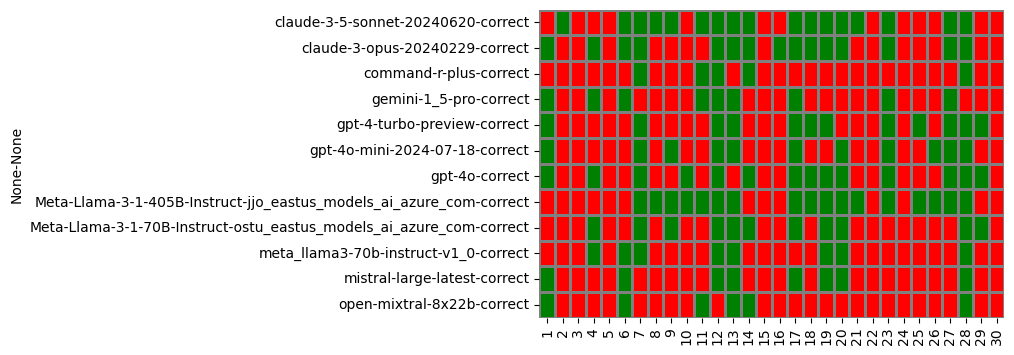

In [66]:
question_correct_df = moe_llm_answers_comb_df[norm_correct_cols + [('bench', 'question')]].groupby([('bench', 'question')]).median().reset_index(drop=True)
question_correct_df.index += 1

plt.figure(figsize=(6, 4))
cmap = sns.color_palette(['red', 'green'])
sns.heatmap(question_correct_df.T, cmap=cmap, cbar=False, linewidths=1, linecolor='grey')
#plt.xticks(rotation=0, ha='right')
None

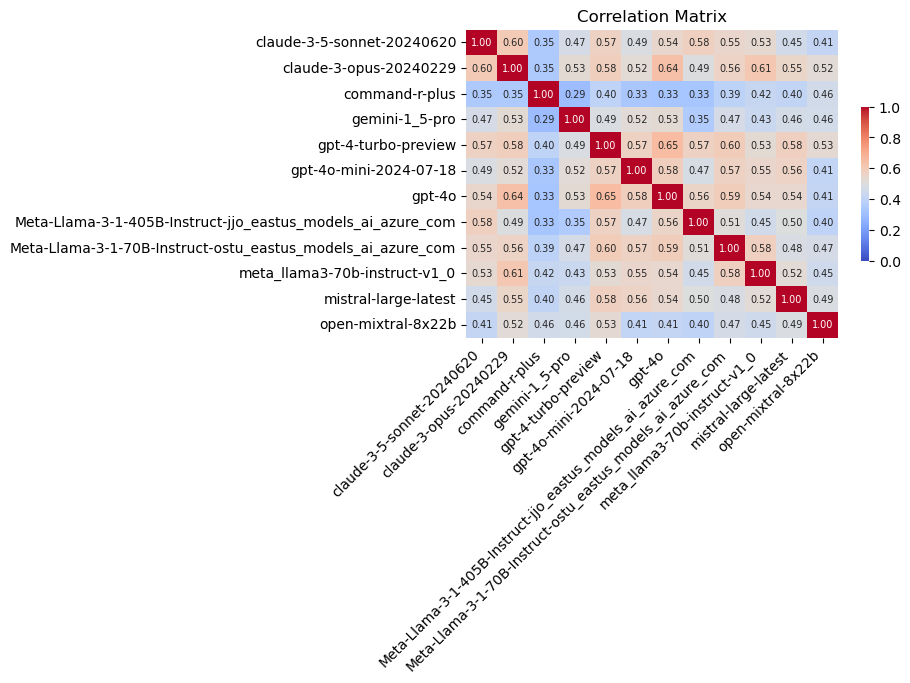

In [49]:
answer_correlations = {}
for (model_base, col) in norm_choice_cols:
    model_correlations = {}
    for (model_test, col) in norm_choice_cols:
        same_answer_percentage = ((moe_llm_answers_comb_df[model_base][col].fillna(0) 
                                   == moe_llm_answers_comb_df[model_test][col].fillna(0))
                                  .value_counts(normalize=True)[True])
        model_correlations[model_test] = same_answer_percentage
    answer_correlations[model_base] = model_correlations

correlation_matrix = pd.DataFrame(answer_correlations)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, 
                 cbar_kws={"shrink": 0.5}, fmt='.2f', annot_kws={'size': 7})
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')
plt.show()

### Run test to see how MOE performs with various permutations of models

In [27]:
# Sanity check to see if model scores match those calculated earlier (because we have done a lot of messing about). 
# It can used as a basis to see if MOE is improving results or not.
result_series = pd.Series({col[0]: (moe_llm_answers_comb_df[col] == moe_llm_answers_comb_df['bench']['normalized_correct_letter']).value_counts(normalize=True)[True] 
 for col in norm_choice_cols})

result_series.sort_values(ascending=False)

Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com    0.546667
claude-3-5-sonnet-20240620                                     0.506667
claude-3-opus-20240229                                         0.443333
gpt-4o                                                         0.420000
gpt-4-turbo-preview                                            0.366667
Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com    0.343333
gpt-4o-mini-2024-07-18                                         0.333333
gemini-1_5-pro                                                 0.310000
mistral-large-latest                                           0.296667
meta_llama3-70b-instruct-v1_0                                  0.290000
open-mixtral-8x22b                                             0.270000
command-r-plus                                                 0.186667
dtype: float64

In [28]:
import numpy as np

def get_most_common_or_random(row):
    # Get the value counts for the row, if all NaNs, return a random choice
    value_counts = row.value_counts()
    if value_counts.empty:  # Check if value_counts is empty (all values are NaN)
        return np.random.choice(['A', 'B', 'C', 'D'])
    else:
        # Find the maximum count
        max_count = value_counts.max()
        # Find the indices (letters) that have the maximum count
        most_common_choices = value_counts[value_counts == max_count].index.tolist()
        # If there's more than one most frequent letter, pick one randomly
        return np.random.choice(most_common_choices)

In [29]:
# subset_norm_choice_cols = [col for col in norm_choice_cols if col[0] in [
#                             'claude-3-5-sonnet-20240620', 
#                             'claude-3-opus-20240229', 
#                             'gemini-1_5-pro', 
#                             'gpt-4o', 
#                             'open-mixtral-8x22b',
#                            ]]

subset_norm_choice_cols = norm_choice_cols

In [30]:

answer_values = moe_llm_answers_comb_df.apply(axis='columns', 
    func=lambda x: x[subset_norm_choice_cols].value_counts())
most_common_answer = moe_llm_answers_comb_df.apply(axis='columns', 
    func=lambda x: get_most_common_or_random(x[subset_norm_choice_cols]), result_type='expand')
largest_common_answer = moe_llm_answers_comb_df.apply(axis='columns', 
    func=lambda x: x[subset_norm_choice_cols].value_counts().max())
answer_values['correct_letter'] = moe_llm_answers_comb_df['bench']['normalized_correct_letter']
answer_values['most_common_answer'] = most_common_answer
answer_values['largest_common_answer'] = largest_common_answer
display(answer_values)

correct = (answer_values['correct_letter'] == answer_values['most_common_answer']).sum() / len(answer_values)
print('Score %:', correct)

,A,B,C,D,correct_letter,most_common_answer,largest_common_answer
0,4.0,5.0,2.0,1.0,A,B,5
1,NaN,7.0,3.0,2.0,D,B,7
2,1.0,5.0,NaN,6.0,D,D,6
3,5.0,1.0,6.0,NaN,B,C,6
4,5.0,NaN,7.0,NaN,A,C,7
...,...,...,...,...,...,...,...
295,2.0,8.0,1.0,1.0,A,B,8
296,4.0,4.0,NaN,4.0,A,B,4
297,7.0,NaN,NaN,5.0,A,A,7
298,2.0,1.0,NaN,9.0,B,D,9


Score %: 0.3933333333333333


0.3933333333333333


<Axes: title={'center': 'Accuracy by Most Common Answer'}, xlabel='largest_common_answer'>

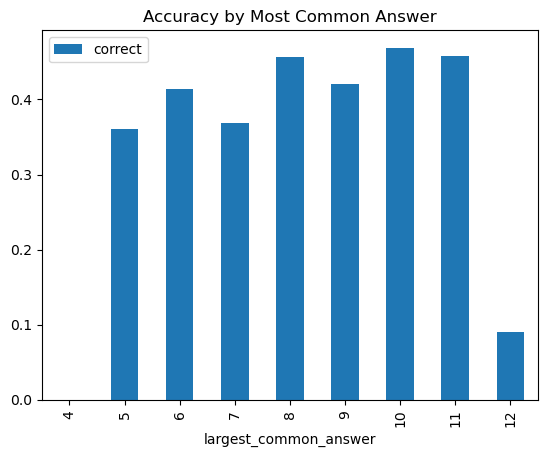

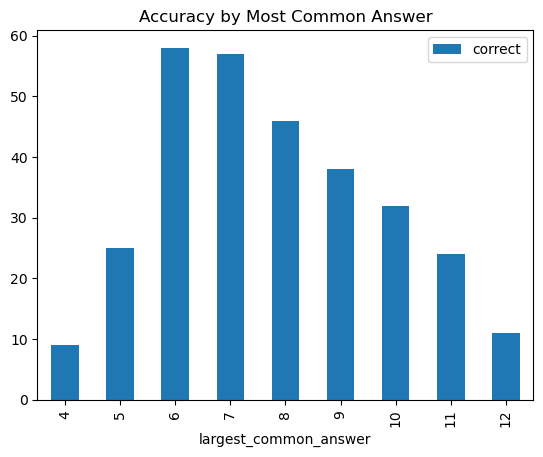

In [31]:
answer_values['correct'] = (answer_values['correct_letter'] == answer_values['most_common_answer']).astype(int)
answer_values[['largest_common_answer', 'correct']].groupby('largest_common_answer').mean().plot(kind='bar', title='Accuracy by Most Common Answer')
answer_values[['largest_common_answer', 'correct']].groupby('largest_common_answer').count().plot(kind='bar', title='Accuracy by Most Common Answer')

In [32]:
from itertools import combinations

def all_combinations(arr):
    x = len(arr)
    all_combos = []
    for r in range(2, x + 1):
        combos = list(combinations(arr, r))
        all_combos.extend(combos)
    return all_combos

all_combos = all_combinations(llm_models)
all_combos

[('claude-3-5-sonnet-20240620', 'claude-3-opus-20240229'),
 ('claude-3-5-sonnet-20240620', 'command-r-plus'),
 ('claude-3-5-sonnet-20240620', 'gemini-1_5-pro'),
 ('claude-3-5-sonnet-20240620', 'gpt-4-turbo-preview'),
 ('claude-3-5-sonnet-20240620', 'gpt-4o-mini-2024-07-18'),
 ('claude-3-5-sonnet-20240620', 'gpt-4o'),
 ('claude-3-5-sonnet-20240620',
  'Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com'),
 ('claude-3-5-sonnet-20240620',
  'Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com'),
 ('claude-3-5-sonnet-20240620', 'meta_llama3-70b-instruct-v1_0'),
 ('claude-3-5-sonnet-20240620', 'mistral-large-latest'),
 ('claude-3-5-sonnet-20240620', 'open-mixtral-8x22b'),
 ('claude-3-opus-20240229', 'command-r-plus'),
 ('claude-3-opus-20240229', 'gemini-1_5-pro'),
 ('claude-3-opus-20240229', 'gpt-4-turbo-preview'),
 ('claude-3-opus-20240229', 'gpt-4o-mini-2024-07-18'),
 ('claude-3-opus-20240229', 'gpt-4o'),
 ('claude-3-opus-20240229',
  'Meta-Llama-3-1-405B-Instruct-jjo_eas

In [33]:
raise

RuntimeError: No active exception to reraise

In [ ]:
from tqdm import tqdm

all_combo_results = {}
for models in tqdm(all_combos):
    subset_norm_choice_cols = [col for col in norm_choice_cols if col[0] in models]
    answer_values = moe_llm_answers_comb_df.apply(axis='columns', 
        func=lambda x: x[subset_norm_choice_cols].value_counts())
    most_common_answer = moe_llm_answers_comb_df.apply(axis='columns', 
        func=lambda x: get_most_common_or_random(x[subset_norm_choice_cols]), result_type='expand')
    largest_common_answer = moe_llm_answers_comb_df.apply(axis='columns', 
        func=lambda x: x[subset_norm_choice_cols].value_counts().max())
    answer_values['correct_letter'] = moe_llm_answers_comb_df['bench']['normalized_correct_letter']
    answer_values['most_common_answer'] = most_common_answer
    answer_values['largest_common_answer'] = largest_common_answer
    #display(answer_values)

    correct = (answer_values['correct_letter'] == answer_values['most_common_answer']).sum() / len(answer_values)
    #print(f'Models: {models} | Score %: {correct}')
    all_combo_results[models] = correct

  2%|▏         | 81/4083 [02:12<1:49:13,  1.64s/it]


KeyboardInterrupt: 

In [ ]:
max_score = 0
for (models, score) in all_combo_results.items():
    if score > max_score:
        max_score = score
        print(f'Models: {models} | Score %: {score}')

Models: ('claude-3-5-sonnet-20240620', 'claude-3-opus-20240229') | Score %: 0.4666666666666667
Models: ('claude-3-5-sonnet-20240620', 'gpt-4o') | Score %: 0.47
Models: ('claude-3-5-sonnet-20240620', 'claude-3-opus-20240229', 'gemini-1_5-pro') | Score %: 0.4766666666666667
Models: ('claude-3-5-sonnet-20240620', 'gemini-1_5-pro', 'gpt-4o') | Score %: 0.4866666666666667
Models: ('claude-3-5-sonnet-20240620', 'claude-3-opus-20240229', 'gemini-1_5-pro', 'gpt-4o', 'open-mixtral-8x22b') | Score %: 0.49


In [ ]:
pd.DataFrame(all_combo_results, index=['score']).T.sort_values(by='score', ascending=False)#.to_csv('./all_combo_results.csv')

score
claude-3-5-sonnet-20240620 claude-3-opus-20240229        gemini-1_5-pro                gpt-4o open-mixtral-8x22b NaN NaN NaN NaN NaN  0.490000
                           gemini-1_5-pro                gpt-4o                        NaN    NaN                NaN NaN NaN NaN NaN  0.486667
                           claude-3-opus-20240229        gemini-1_5-pro                NaN    NaN                NaN NaN NaN NaN NaN  0.476667
                           gpt-4o                        NaN                           NaN    NaN                NaN NaN NaN NaN NaN  0.470000
                           claude-3-opus-20240229        gemini-1_5-pro                gpt-4o NaN                NaN NaN NaN NaN NaN  0.466667
...                                                                                                                                        ...
command-r                  meta_llama3-70b-instruct-v1_0 NaN                           NaN    NaN                NaN NaN NaN NaN NaN  0.253333
                           gemini-1_0-pro                meta_llama3-70b-instruct-v1_0 NaN    NaN                NaN NaN NaN NaN NaN  0.246667
gemini-1_0-pro             mistral-large-latest          NaN                           NaN    NaN                NaN NaN NaN NaN NaN  0.246667
                           meta_llama3-70b-instruct-v1_0 NaN                           NaN    NaN                NaN NaN NaN NaN NaN  0.236667
command-r                  gemini-1_0-pro                NaN                           NaN    NaN                NaN NaN NaN NaN NaN  0.236667

[1013 rows x 1 columns]